In [1]:
import numpy as np
import pandas as pd
import random
from numpy.linalg import cholesky
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

In [2]:
class Cellule_araignee:
    
    def __init__(self, val, x, y):
        self.valeur = val
        self.fils = []
        self.x = x
        self.y = y
        
    def _neigh(self, R, max_x, max_y):
        neighs = []
        for i in range(max(self.x-R, 0), min(self.x+R+1, max_x)):
            for j in range(max(self.y-R, 0), min(self.y+R+1, max_y)):
                neighs.append((i,j))
        neighs.remove((self.x, self.y))
        return neighs
        
    def _scut(self, ):     
        scuts = []
        if (len(self.fils) != 0):
            scuts = [f[0] for f in self.fils]
        return scuts
        
    def _access(self, R):
        neighs = self._neigh(R)
        scut = self._scut()
        return neighs+scut
    
    def _nombre1(self, b):
        res = 0
        for f in self.fils:
            res += int(f[0]==b)
        return res
        
    def _nombre2(self, b, nom): 
        res = 0
        for f in self.fils:
            res += int(f[0]==b and f[1]==nom)
        return res
        
    def _ajout_fil(self, b, nom):
        f = []
        f.append(b)
        f.append(nom)
        self.fils.append(f)
    

In [37]:
class Araignee:
    
    def __init__(self, p, pback, a1, a2, x, y, R, nom, cellule, max_x, max_y, envir, const, s, reflevel, percep):
        
        # probabilité de suivre un fil et probabililté de retourner au web
        self.proba_fil = p
        self.proba_back = pback
        
        # self attraction and other attraction
        self.attract_self = a1
        self.attract_other = a2
        
        # la taille de l'environnement
        self.MAX_x = max_x 
        self.MAX_y = max_y
        
        # la position de l'araignee
        self.x = x
        self.y = y
        
        # le rayon pour aller plus loin, autrement dit, la limite de perception
        self.R = R
        
        # le cellule où l'araignee se trouve
        self.cellule = cellule
        self.dernier_cellule_x = self.x
        self.dernier_cellule_y = self.y
        
        # le nom du groupe de l'araignée
        self.groupe_nom = nom
        
        # initialisation le reflevel par la valeur de cellule initiale
        # sera mis à jour par la moyenne des cellules
        self.RefLevel = reflevel
        
        self.Selectivity = s
        self.environnement = envir
        
        self.const = const
        self.percep = percep
        
    def _comportement(self):
        p = random.random()
        if (p < self.proba_back):
            self.retour_web()
        else:
            p = random.random()
            #print(self.x, self.y)
            if (p < self.proba_fil):
                self._poser_fil()
                #print(1)
            else:
                self._suivre_fil()
            
        
        
    def _suivre_fil(self):
        neigh = self.cellule._neigh(self.R, self.MAX_x, self.MAX_y)
        scut = self.cellule._scut()
        access = list(set(neigh+scut))
        
        scores = []
        score = 0
        for c in access:
            if c in neigh:
                score += self.const
            if c in scut:
                score += self.attract_self*self._f(self.cellule._nombre1(c))+self.attract_other*self._f(self.cellule._nombre2(c, self.groupe_nom))
                #print(self.attract_self*self._f(self.cellule._nombre1(c))+self.attract_other*self._f(self.cellule._nombre2(c, self.groupe_nom)))
            scores.append(score)
            
        scores = [s/scores[len(scores)-1] for s in scores]
        p = random.random()
        k = 0
        while (p>scores[k]) and (k<len(access)):
            k += 1

        self.x = access[k][0]
        self.y = access[k][1]
        self.cellule = self.environnement[self.x][self.y]
            
    def _f(self, i):
        return min(i, 50)
        
    def _poser_fil(self):
        
        # générer nouvelle position à poser le fil
        s = np.random.normal(self.RefLevel, 1/self.Selectivity, 1)# random une valeur suit la loi normale
        x_l = []
        y_l = []
        diff = 10000 # initialisation une différence assez grande
        for i in range(max(0, self.x-self.percep), min(self.MAX_x, self.x+self.percep+1)):
            for j in range(max(0, self.y-self.percep), min(self.MAX_y, self.y+self.percep+1)):
                #print(i, j)
                if (abs(self.environnement[i][j].valeur-s)<diff) and not ((i==self.x) and (j==self.y)):
                    diff = self.environnement[i][j].valeur-s                    
                    x_l = [i]
                    y_l = [j]
                #print(x_n, y_n)
                if (abs(self.environnement[i][j].valeur-s)<diff) and not ((i==self.x) and (j==self.y)):
                    x_l.append(i)
                    y_l.append(j)
                    
        # mis à jour les informations
        ind = random.randint(0,len(x_l)-1)
        self.x = x_l[ind]
        self.y = y_l[ind]
        self.cellule._ajout_fil((self.environnement[self.x][self.y].x, self.environnement[self.x][self.y].y), self.groupe_nom)
        self.cellule = self.environnement[self.x][self.y]
        self.dernier_cellule_x = self.x
        self.dernier_cellule_y = self.y
        
    def retour_web(self):
        self.x = self.dernier_cellule_x
        self.y = self.dernier_cellule_y
        self.celleule = self.environnement[self.x][self.y]
        

In [38]:
class Environnement_araignee:
    
    def __init__(self, M, N, groupes, nb_ite, proba_fil, proba_back, att_self, att_other, R, const, slct, reflevel, percep, x_list, y_list):
        """
        M: matrice de l'envrionnement, 
        N: nombre de araignées
        groupes: liste du nom de la groupe des araignées
        nb_ite: nombre de l'itération
        """   
        self.n, self.p = M.shape
        #print(M.shape)
        
        self.environnement = []
        for i in range(self.n):
            lig = []
            for j in range(self.p):
                lig.append(Cellule_araignee(M[i,j], i, j))
            self.environnement.append(lig)
        
        self.nba = N
        self.groupes = groupes
        self.araignees = []

        for i in range(self.nba):
            #g = random.randint(0,len(self.groupes)-1)
            y = y_list[i]
            x = x_list[i]
            #print(x, y)
            self.araignees.append(Araignee(proba_fil, proba_back, att_self, att_other, x, y, R, self.groupes[i], self.environnement[x][y], self.n, self.p, self.environnement, const, slct, reflevel, percep))
        #for a in self.araignees:
            #print(a.x, a.y)
        for i in tqdm(range(nb_ite)):
            for a in self.araignees:
                a._comportement()
            #self.affichage()
    
    def affichage(self):
        for i in range(self.n):
            for j in range(self.p):
                print(i, j, self.environnement[i][j].fils)


In [154]:
def segmentation_plot(M, img, nom):
    img1 = img.copy()
    plt.figure(figsize=(6, 12))
    colors = [(0, 255, 255), (255, 0, 255), (50, 205, 50), (255, 255, 0), (105, 90, 205), (50, 50, 50)]#, (255, 255, 0), (105, 90, 205), (35, 45, 55)]
    for i in range(len(M)):
        for j in range(len(M[0])):
            fils = algo.environnement[i][j].fils
            start = (j, i)
            for p in fils:
                #print(p[0][0], p[0][1], colors[groupes.index(p[1])])
                stop = (p[0][1], p[0][0])        
                color = colors[groupes.index(p[1])]
                thick = 1
                cv2.line(img1,start,stop,color,thick)
    plt.imshow(img1)
    plt.savefig(nom, bbox_inches='tight')
    

In [155]:
def contour_plot(M, nom):
    img2 = np.zeros((256, 182, 3),np.uint8)
    plt.figure(figsize=(6, 12))
    color = (255, 255, 255)
    for i in range(len(M)):
        for j in range(len(M[0])):
            fils = algo.environnement[i][j].fils
            start = (j, i)
            for p in fils:
                stop = (p[0][1], p[0][0]) 
                cv2.line(img2,start,stop,color)
    plt.imshow(img2)
    plt.savefig(nom, bbox_inches='tight')

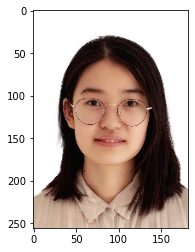

100%|██████████| 10000/10000 [00:11<00:00, 866.68it/s]


In [210]:
img = cv2.imread("IMG_1314.PNG")[:,:,[2,1,0]]
img = cv2.resize(img, (182, 256))
#plt.figure(figsize = (6, 12))
plt.imshow(img)
plt.show()
#print(M.shape)
M = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

groupes = ['A', 'B', 'C', 'D', 'E']
nba = 5
nb_ite = 10000
proba_fil = 0.3
proba_back = 0.1
att_self = 1
att_other = .2
R = 1
const = 1
reflevel = 1
slct = 2 #selectivite
percep = 2
x_init = [80, 200, 150, 200, 60]
y_init = [50, 40, 150, 150, 125]
algo = Environnement_araignee(np.array(M), nba, groupes, nb_ite, proba_fil, proba_back, att_self, att_other, R, const, slct, reflevel, percep, x_init, y_init)


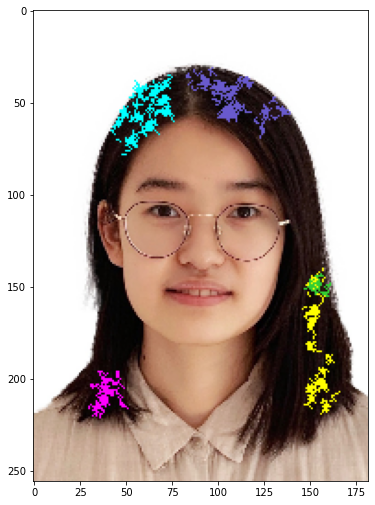

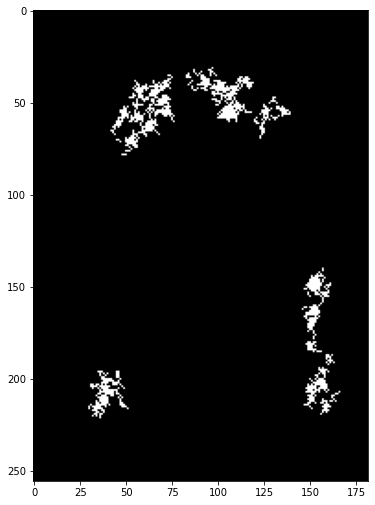

In [211]:
segmentation_plot(M, img, "tonglin_const_.5.png")
contour_plot(M, "contour_tonglin_const_.5.png")

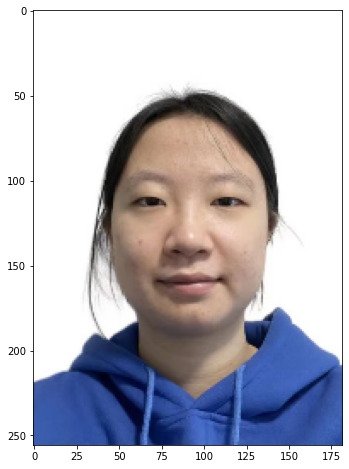

100%|██████████| 20000/20000 [00:41<00:00, 476.80it/s]


In [9]:
img = cv2.imread("WechatIMG19047.jpeg")[:,:,[2,1,0]]
img = cv2.resize(img, (182, 256))
plt.figure(figsize = (12, 6))
plt.imshow(img)
plt.show()

M = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
groupes = ['A', 'B', 'C', 'D', 'E']
nba = 4
nb_ite = 20000

# probabilité
proba_fil = 0.2
proba_back = 0

# attraction
att_self = 1
att_other = 1
R = 1
const = 1
reflevel = 1
slct = 1 #selectivite
percep = 2
x_init = [90, 60, 55, 65, 100]
y_init = [50, 75, 100, 120, 130]
algo = Environnement_araignee(np.array(M), nba, groupes, nb_ite, proba_fil, proba_back, att_self, att_other, R, const, slct, reflevel, percep, x_init, y_init)


100%|██████████| 256/256 [00:00<00:00, 5866.61it/s]


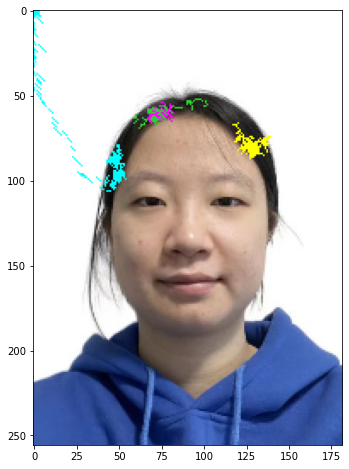

In [10]:
img1 = img.copy()
colors = [(0, 255, 255), (255, 0, 255), (50, 205, 50), (255, 255, 0), (105, 90, 205)]#, (255, 255, 0), (105, 90, 205), (35, 45, 55)]
for i in tqdm(range(len(M))):
    for j in range(len(M[0])):
        fils = algo.environnement[i][j].fils
        start = (j, i)
        for p in fils:
            #print(p[0][0], p[0][1], colors[groupes.index(p[1])])
            stop = (p[0][1], p[0][0])        
            color = colors[groupes.index(p[1])]
            thick = 1
            cv2.line(img1,start,stop,color,thick)
plt.figure(figsize=(12, 8))
plt.imshow(img1)
plt.savefig("segmentation_diandian")
#cv2.waitKey()